In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

#Import Data Loaders
from Imports import SIRDataset

#Import Models
from Imports import SIRNetwork
from Imports import ImprovedSIRNetwork
from Imports import ResNetSIR

In [2]:

##################################################
## Define the SIR model for comparison
##################################################
def SIR(beta,gamma,S0,I0,tf,Num,r_ruido):
    N = S0 + I0
    t = np.linspace(0,tf,Num)
    dt = t[1] - t[0]
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))
    S[0] = S0
    I[0] = I0

    for i in range(len(t)-1):
        dS = -beta*I[i]*S[i]/N
        dI = beta*I[i]*S[i]/N - gamma*I[i]
        dR = gamma*I[i]

        S[i+1] = S[i] + dS*dt
        I[i+1] = I[i] + dI*dt
        R[i+1] = R[i] + dR*dt

    #t = t + np.random.uniform(-1, 1, size=len(t))
    S = S + N*np.random.normal(0, r_ruido, size=len(t))
    I = I + N*np.random.normal(0, r_ruido, size=len(t))
    R = R + N*np.random.normal(0, r_ruido, size=len(t))

    return list(np.abs(S)),list(np.abs(I)),list(np.abs(R))  #,list(t) 

In [3]:
scaler_S = RobustScaler()
scaler_I = RobustScaler()
scaler_R = RobustScaler()   
beta_scaler = RobustScaler()
gamma_scaler = RobustScaler()

DataSetSIR = np.load("DataSetSIR6.npz")

S_loaded = DataSetSIR['S_']
I_loaded = DataSetSIR['I_']
R_loaded = DataSetSIR['R_']
Beta_loaded = DataSetSIR['Beta_']
gamma_loaded = DataSetSIR['gamma_']

S = scaler_S.fit_transform(S_loaded)
I = scaler_I.fit_transform(I_loaded)
R= scaler_R.fit_transform(R_loaded)
Beta = beta_scaler.fit_transform(Beta_loaded.reshape(-1, 1)).squeeze()
gamma = gamma_scaler.fit_transform(gamma_loaded.reshape(-1, 1)).squeeze()

gamma = DataSetSIR['gamma_']
Beta = DataSetSIR['Beta_']

In [27]:
#mat = scipy.io.loadmat('reto1.mat')
mat = np.array(pd.read_csv("caso_b.csv"))

#S_eval = mat['S']
#I_eval = mat['I']
#R_eval = mat['R']

S_eval = mat[0]
I_eval = mat[1]
R_eval = mat[2]

S_scaled = scaler_S.transform(S_eval.reshape(1, -1))
I_scaled = scaler_I.transform(I_eval.reshape(1, -1))
R_scaled = scaler_R.transform(R_eval.reshape(1, -1))

In [28]:
# Initialize the model
n = len(S[0])  # Assuming S, I, and R lists all have the same length
SIRmodel = SIRNetwork(input_size=3*100)

# Load the model parameters
SIRmodel.load_state_dict(torch.load('sir_model_params_6_1.pth'))

# Set the model to evaluation mode
SIRmodel.eval()

SIRNetwork(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [29]:
# Assume new_S, new_I, new_R are your new data tensors
# Make sure to preprocess these tensors in the same way as your training data
n_sim = 2365

input_data =np.concatenate((S_scaled, I_scaled, R_scaled), axis=1)
#input_data =np.concatenate((S[n_sim].reshape(1,100), I[n_sim].reshape(1,100), R[n_sim].reshape(1,100)), axis=1)

input_data = torch.tensor(input_data, dtype=torch.float32)

# Make sure to add an extra dimension to match the input shape requirement of the model
#input_data = input_data.unsqueeze(0)

# Pass the data through the model to get predictions
with torch.no_grad():
    predictions = SIRmodel(input_data)

# Extract beta and gamma
beta_inverse_transformed = float(beta_scaler.inverse_transform(predictions[:, 0].detach().numpy().reshape(-1, 1)))
gamma_inverse_transformed = float(gamma_scaler.inverse_transform(predictions[:, 1].detach().numpy().reshape(-1, 1)))

#print(f"Predicted Beta: {beta_inverse_transformed}, Actual Beta: {Beta[n_sim]}, Predicted Gamma: {gamma_inverse_transformed}, Actual Gamma: {gamma[n_sim]}")
print(f"Predicted Beta: {beta_inverse_transformed}, Predicted Gamma: {gamma_inverse_transformed}")

Predicted Beta: 0.5201899409294128, Predicted Gamma: 0.2614881694316864


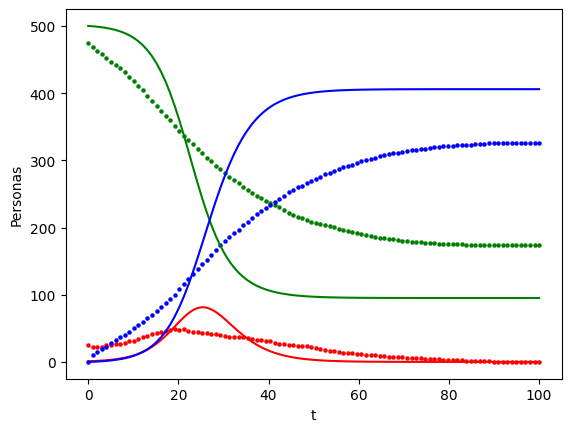

In [30]:
t = np.linspace(0,100,100)
t_eval = np.linspace(0,100,100)

S_pred, I_pred, R_pred = SIR(beta_inverse_transformed,gamma_inverse_transformed,500,1,100,100,0)    

plt.plot(t,S_pred,color='green')
plt.plot(t,I_pred,color='red')
plt.plot(t,R_pred,color='blue')
plt.scatter(t_eval,S_eval,color='green',s=5)
plt.scatter(t_eval,I_eval,color='red',s=5)
plt.scatter(t_eval,R_eval,color='blue',s=5)

plt.ylabel("Personas")
plt.xlabel("t")

plt.show()

#### Error histograms

In [8]:
sir_data = SIRDataset(S, I, R, Beta, gamma)
sir_data_inputs = DataLoader(sir_data)

Outputs = np.zeros([len(S),2])

with torch.no_grad():
    for i, data in enumerate(sir_data_inputs, 0):
        # Get inputs
        inputs, targets = data
        # Perform forward pass (make sure to supply the input in the right way)
        outputs = SIRmodel(inputs)

        Outputs[i,0] = float(outputs[0,0])
        Outputs[i,1] = float(outputs[0,1])

Beta_pred = beta_scaler.inverse_transform(Outputs[:,0].reshape(-1, 1))
Beta_pred = Beta_pred.reshape(len(Beta_pred))
gamma_pred = gamma_scaler.inverse_transform(Outputs[:,1].reshape(-1, 1))
gamma_pred = gamma_pred.reshape(len(gamma_pred))

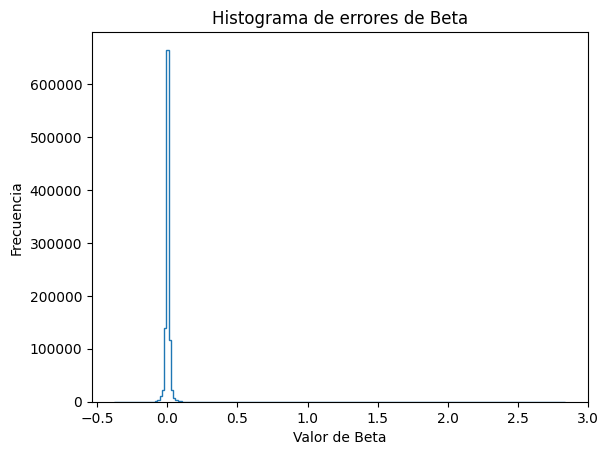

In [9]:
#histograma de errores para Beta
Beta_error = Beta_loaded-Beta_pred

plt.hist(Beta_error,bins=200,histtype='step')
plt.xlabel('Valor de Beta')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores de Beta')

plt.show()

In [13]:
error_beta_mean = np.mean(Beta_error)
error_beta_std = np.std(Beta_error)

print(f'La media de los errores en Beta es de {error_beta_mean:.4f}')
print(f'La desviación estándar de los errores en Beta es de {error_beta_std:.3f}')

La media de los errores en Beta es de -0.0004
La desviación estándar de los errores en Beta es de 0.019


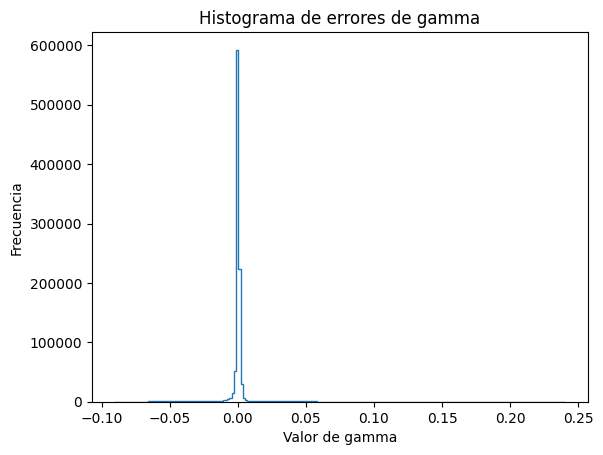

In [11]:
#histograma de errores para Beta
gamma_error = gamma_loaded-gamma_pred

plt.hist(gamma_error,bins=200,histtype='step')
plt.xlabel('Valor de gamma')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores de gamma')

plt.show()


In [14]:
error_gamma_mean = np.mean(gamma_error)
error_gamma_std = np.std(gamma_error)

print(f'La media de los errores en gamma es de {error_gamma_mean:.4f}')
print(f'La desviación estándar de los errores en gamma es de {error_gamma_std:.3f}')

La media de los errores en gamma es de 0.0002
La desviación estándar de los errores en gamma es de 0.011
